In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from geo_tool import Point_Cloud

import tf_lab.autopredictors.scripts.minhyuk_data as minhyuk_data
from tf_lab.autopredictors.scripts.minhyuk_data import KinectData
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import unpickle_data
from general_tools.in_out.basics import create_dir

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
incomplete_n_samples = 2048
complete_n_samples = 4096
normalize_data = True        # Transforms input data to follow basic patterns of our training ShapeNet data.

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
predictor_loss = 'emd'

# category_name = assembly_chairs or coseg_chairs or assembly_airplanes or shapenet_tables
category_name = 'coseg_chairs'  

# predictor_type = 'chair', or 'table', or 'airplane', or all_classes_in_dai'
predictor_type = 'chair' 

In [6]:
gt_pclouds, gt_names = minhyuk_data.groundtruth_point_clouds(category_name, complete_n_samples)
m_completions, gt_names_2 = minhyuk_data.minhyuk_completions(category_name, complete_n_samples)
partial_pclouds, gt_names_3 = minhyuk_data.incomplete_point_clouds(category_name, incomplete_n_samples)

assert(np.alltrue(gt_names == gt_names_2))
assert(np.alltrue(gt_names == gt_names_3))

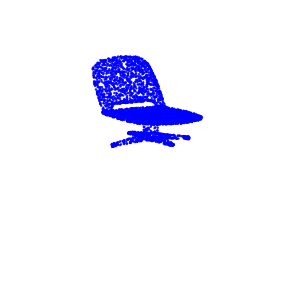

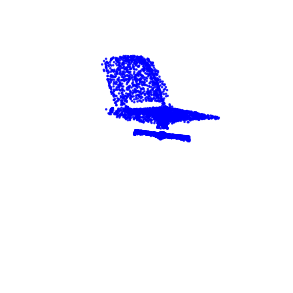

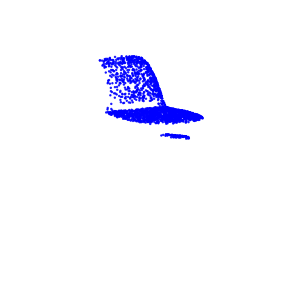

In [206]:
# RUN to see gt-completion-partial triplets are aligned.
rid = np.random.randint(len(gt_pclouds))
Point_Cloud(gt_pclouds[rid]).plot(show_axis=False, in_u_sphere=True);
Point_Cloud(m_completions[rid]).plot(show_axis=False, in_u_sphere=True);
Point_Cloud(partial_pclouds[rid]).plot(show_axis=False, in_u_sphere=True);

In [7]:
if normalize_data:
    rot_degrees = minhyuk_data.rotation_degrees[category_name]
    _, partial_pclouds = minhyuk_data.normalize_point_clouds(gt_pclouds, partial_pclouds, rot_degrees)    
    gt_pclouds, m_completions = minhyuk_data.normalize_point_clouds(gt_pclouds, m_completions, rot_degrees)

In [8]:
def accuracy_coverage_stats(gt_pclouds, predictions, thres=0.02):
    n_examples = gt_pclouds.shape[0]
    scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = gt_pclouds[i]
        pred = predictions[i]
        scores[i, 0] = accuracy_of_completion(pred, gt, thres=thres, ret_dists=False)
        scores[i, 1] = coverage_of_completion(gt, pred, thres=thres, ret_dists=False)

    return scores

In [9]:
sung_pred_scores = accuracy_coverage_stats(gt_pclouds, m_completions)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 0]), np.median(sung_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 1]), np.median(sung_pred_scores[:, 1]))

Accuracy: Mean 0.832, Median 0.875
Coverage: Mean 0.717, Median 0.709


In [ ]:
predictor_name = predictor_type + '_2048_4096pts_' + predictor_loss + '_original'
predictor_train_dir = osp.join(top_data_dir, 'OUT/iccv/nn_models/', predictor_name)

best_epoch, val_loss = unpickle_data(osp.join(predictor_train_dir, 'validation_stats.pickle'))

conf = Conf.load(osp.join(predictor_train_dir, 'configuration'))
reset_tf_graph()
predictor = PointNetAutoEncoder(predictor_name, conf)
predictor.restore_model(predictor_train_dir, best_epoch, verbose=True)

Model restored in epoch 90.


In [ ]:
test_data = PointCloudDataSet(gt_pclouds, labels=gt_names, noise=partial_pclouds, init_shuffle=False)
our_pred, loss, feed, ids, gt = predictor.evaluate(test_data, conf)

In [ ]:
our_pred_scores = accuracy_coverage_stats(gt_pclouds, our_pred)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 0]), np.median(our_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 1]), np.median(our_pred_scores[:, 1]))